In [2]:
import pandas as pd
import numpy as np
import dask.dataframe as dd 
import matplotlib.pyplot as plt
import json
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from sklearn.ensemble import RandomForestClassifier

In [2]:
cali_reviews = "C:/review-California_10.json"
cali_business = "C:/Users/cbrun/OneDrive/Documents/inspection_proj/meta-California.json"
cali_inspections = "C:/Users/cbrun/OneDrive/Documents/inspection_proj/Inspections.csv"
ill_inspections = "C:/Users/cbrun/Downloads/Food_Inspections_20250723.csv"
ill_business = "C:/Users/cbrun/Downloads/meta-Illinois.json"

## Load Data

In [3]:
df = dd.read_json(ill_business,blocksize=2**28)
ill_business_df = df.compute()
df = dd.read_json(cali_business,blocksize=2**28)
cali_business_df = df.compute()
cali_inspect_df = pd.read_csv(cali_inspections)
ill_inspect_df = pd.read_csv(ill_inspections)

## Clean Data

In [8]:
#clean business dataset
ill_business_df['name'] = ill_business_df['name'].str.lower()
ill_business_df['address'] = ill_business_df['address'].str.lower()
cali_business_df['name'] = cali_business_df['name'].str.lower()
cali_business_df['address'] = cali_business_df['address'].str.lower()
cali_business_df.drop(['description','hours','MISC','relative_results','url','state','price'],axis=1,inplace=True)
ill_business_df.drop(['description','hours','MISC','relative_results','url','state','price'],axis=1,inplace=True)

KeyError: "['description', 'hours', 'MISC', 'relative_results', 'url', 'state', 'price'] not found in axis"

In [9]:
# can only connect business to inspections via address, drop all occurences where address is na
cali_business_df = cali_business_df.dropna(subset=['address'])
cali_business_df = cali_business_df.drop_duplicates(subset=['gmap_id'])
ill_business_df = ill_business_df.dropna(subset=['address'])
ill_business_df = ill_business_df.drop_duplicates(subset=['gmap_id'])

In [10]:
#clean inspection dataset
ill_inspect_df['AKA Name'] = ill_inspect_df['AKA Name'].str.lower()
ill_inspect_df['Address'] = ill_inspect_df['Address'].str.lower()
cali_inspect_df['facility_name'] = cali_inspect_df['facility_name'].str.lower()
cali_inspect_df['facility_address'] = cali_inspect_df['facility_address'].str.lower()
ill_inspect_df.drop(['License #','Facility Type','Latitude','Longitude','Location'],axis=1,inplace=True)

KeyError: "['License #', 'Facility Type', 'Latitude', 'Longitude', 'Location'] not found in axis"

In [11]:
#Since we want to use both inspections in the same dataset, we need to make the results from the two compatible
#The results will be converting into either pass or fail with all other outcomes discarded
#for illinois inspection,
np.unique(ill_inspect_df['Results'])
ill_inspect_df['Results'] = ill_inspect_df['Results'].replace('Pass w/ Conditions', 'Pass')
ill_inspect_df = ill_inspect_df[ill_inspect_df['Results'].isin(['Pass','Fail'])]

In [12]:
#for california inspection,
cali_inspect_df['grade'].dropna(inplace=True)
cali_inspect_df['grade'] = cali_inspect_df['grade'].astype(str)
np.unique(cali_inspect_df['grade'])
cali_inspect_df['grade'] = cali_inspect_df['grade'].replace(['A','B'], 'Pass')
cali_inspect_df['grade'] = cali_inspect_df['grade'].replace('C', 'Fail')
cali_inspect_df = cali_inspect_df[cali_inspect_df['grade'].isin(['Pass','Fail'])]

## merge datasets

In [13]:
#want to use serial number and inspection id as unique indicator, check for overlap
# set(cali_inspect_df['serial_number']) & set(ill_inspect_df['Inspection ID'])
#reassign column names to match 
ill_inspect_df.rename(columns={'Inspection ID':'inspection_id','AKA Name':'name','Address':'address','Results':'outcome','Inspection Date':'inspection_date'},inplace=True)
cali_inspect_df.rename(columns={'serial_number':'inspection_id','facility_name':'name','facility_address':'address','grade':'outcome','activity_date':'inspection_date'},inplace=True)

In [14]:
ill_violations = ill_inspect_df[['inspection_id','name','address','inspection_date','outcome','Violations','Risk']]

In [15]:
#combine inspections
keep_columns = ['inspection_id','name','address','outcome','inspection_date']
combined_inspections = pd.concat([ill_inspect_df[keep_columns],cali_inspect_df[keep_columns]],ignore_index=True)

In [16]:
len(cali_inspect_df)+len(ill_inspect_df)==len(combined_inspections)

True

In [17]:
combined_inspections

,inspection_id,name,address,outcome,inspection_date
0,2620984,shawarma garden,1951 w division st,Pass,07/21/2025
1,2621017,lolas coney island,2858 w chicago ave,Fail,07/21/2025
2,2621011,cheng chopsticks,3054 w armitage ave,Fail,07/21/2025
3,2621013,paisans pizzeria,2150 n cicero ave,Fail,07/21/2025
4,2620936,jk food & deli,1325 n central ave,Pass,07/21/2025
...,...,...,...,...,...
320715,DAZZ4BFUD,ramen maruya,104 japanese village plz mall,Pass,2018-06-15
320716,DAZZ4TRBY,kang won do,4050 w washington blvd,Pass,2018-05-16
320717,DAZZ9YUS4,oasis market,4312 wall st,Pass,2018-04-20
320718,DAZZJBQUO,ten ten yu ramen,2012 sawtelle blvd,Pass,2018-04-17


In [19]:
#combine businesses
combined_business = pd.concat([cali_business_df,ill_business_df],ignore_index=True)
print(len(combined_business) == len(cali_business_df)+len(ill_business_df))
combined_business

True


,name,address,gmap_id,latitude,longitude,category,avg_rating,num_of_reviews
0,city textile,"city textile, 3001 e pico blvd, los angeles, c...",0x80c2c98c0e3c16fd:0x29ec8a728764fdf9,34.018891,-118.215290,['Textile exporter'],4.5,6
1,san soo dang,"san soo dang, 761 s vermont ave, los angeles, ...",0x80c2c778e3b73d33:0xbdc58662a4a97d49,34.058092,-118.292130,['Korean restaurant'],4.4,18
2,nova fabrics,"nova fabrics, 2200 e 11th st, los angeles, ca ...",0x80c2c89923b27a41:0x32041559418d447,34.023669,-118.232930,['Fabric store'],3.3,6
3,nobel textile co,"nobel textile co, 719 e 9th st, los angeles, c...",0x80c2c632f933b073:0xc31785961fe826a6,34.036694,-118.249421,['Fabric store'],4.3,7
4,matrix international textiles,"matrix international textiles, 1363 s bonnie b...",0x80c2cf163db6bc89:0x219484e2edbcfa41,34.015505,-118.181839,['Fabric store'],3.5,6
...,...,...,...,...,...,...,...,...
681584,flat top grill,"flat top grill, 30 s wabash ave, chicago, il 6...",0x880e2ca48983cdf1:0x5d2a67e1d520723e,41.881128,-87.626389,"['Asian fusion restaurant', 'Health food resta...",4.2,1696
681585,lou malnati's pizzeria,"lou malnati's pizzeria, 805 s state st, chicag...",0x880e2c99f4fba789:0x3391da854435bd98,41.871561,-87.627286,"['Pizza restaurant', 'Caterer', 'Pizza deliver...",4.5,6212
681586,the gage,"the gage, 24 s michigan ave, chicago, il 60603",0x880e2ca46b2bafe5:0x1d0780a2c49db10,41.881327,-87.624692,"['American restaurant', 'Cocktail bar', 'Gastr...",4.5,2882
681587,sushi-san,"sushi-san, 63 w grand ave, chicago, il 60654",0x880e2cb237a797c7:0xc4b7bcfdc7520f95,41.891496,-87.630490,['Sushi restaurant'],4.5,1008


In [20]:
#gets businesses that are the same by name in inspection and business
name_inspect_match = pd.merge(combined_business[['name','address','gmap_id','category']],combined_inspections[['name','address','inspection_date','outcome','inspection_id']],left_on=['name'],right_on=['name'])
business_inspections = name_inspect_match.loc[name_inspect_match.apply(lambda row: row['address_y'] in row['address_x'], axis=1)]


In [21]:
business_inspections.drop(columns=['address_y'],inplace=True)

C:\Users\cbrun\AppData\Local\Temp\ipykernel_32800\2949020425.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_inspections.drop(columns=['address_y'],inplace=True)


In [22]:
business_inspections.drop_duplicates(inplace=True)
business_inspections.drop_duplicates(['inspection_id'],inplace=True)
business_inspections['inspection_date'] = pd.to_datetime(business_inspections['inspection_date'],format='mixed')

C:\Users\cbrun\AppData\Local\Temp\ipykernel_32800\3382065787.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_inspections.drop_duplicates(inplace=True)
C:\Users\cbrun\AppData\Local\Temp\ipykernel_32800\3382065787.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_inspections.drop_duplicates(['inspection_id'],inplace=True)
C:\Users\cbrun\AppData\Local\Temp\ipykernel_32800\3382065787.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

In [23]:
business_inspections.sort_values(by='inspection_date')
def prev_dates(d):
    d = d.sort_values(by='inspection_date')
    d['prev_date'] = d['inspection_date'].shift(1)
    d['prev_inspection_outcome'] = d['outcome'].shift(1)
    return d
business_inspections = business_inspections.groupby('gmap_id',group_keys=False).apply(prev_dates)

C:\Users\cbrun\AppData\Local\Temp\ipykernel_32800\4227060127.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  business_inspections = business_inspections.groupby('gmap_id',group_keys=False).apply(prev_dates)


In [24]:
business_inspections

,name,address_x,gmap_id,category,inspection_date,outcome,inspection_id,prev_date,prev_inspection_outcome
2183083,tacos mx,"tacos mx, 312 w 7th st, los angeles, ca 90014",0x14e1b0df6d819dab:0x928b6349b7fbe2f4,['Mexican restaurant'],2015-12-08,Pass,DAFDMYS80,NaT,None
2183082,tacos mx,"tacos mx, 312 w 7th st, los angeles, ca 90014",0x14e1b0df6d819dab:0x928b6349b7fbe2f4,['Mexican restaurant'],2016-03-25,Pass,DATV8ZQNH,2015-12-08,Pass
2183081,tacos mx,"tacos mx, 312 w 7th st, los angeles, ca 90014",0x14e1b0df6d819dab:0x928b6349b7fbe2f4,['Mexican restaurant'],2016-06-27,Pass,DA7UP4JHT,2016-03-25,Pass
2183080,tacos mx,"tacos mx, 312 w 7th st, los angeles, ca 90014",0x14e1b0df6d819dab:0x928b6349b7fbe2f4,['Mexican restaurant'],2016-09-27,Pass,DAPWSHAV9,2016-06-27,Pass
2183079,tacos mx,"tacos mx, 312 w 7th st, los angeles, ca 90014",0x14e1b0df6d819dab:0x928b6349b7fbe2f4,['Mexican restaurant'],2017-05-17,Pass,DAHBLSJCW,2016-09-27,Pass
...,...,...,...,...,...,...,...,...,...
6027391,johnnie's new york pizzeria,"johnnie's new york pizzeria, 10251 santa monic...",0x89c258e4f4f70661:0xa11e8e045190545e,"['Pizza restaurant', 'Chicken wings restaurant...",2016-09-20,Pass,DAT8ADYQT,2016-05-23,Pass
6027387,johnnie's new york pizzeria,"johnnie's new york pizzeria, 10251 santa monic...",0x89c258e4f4f70661:0xa11e8e045190545e,"['Pizza restaurant', 'Chicken wings restaurant...",2017-02-02,Pass,DADRTNOYP,2016-09-20,Pass
6027385,johnnie's new york pizzeria,"johnnie's new york pizzeria, 10251 santa monic...",0x89c258e4f4f70661:0xa11e8e045190545e,"['Pizza restaurant', 'Chicken wings restaurant...",2017-06-27,Pass,DAB7EFZ6L,2017-02-02,Pass
6027390,johnnie's new york pizzeria,"johnnie's new york pizzeria, 10251 santa monic...",0x89c258e4f4f70661:0xa11e8e045190545e,"['Pizza restaurant', 'Chicken wings restaurant...",2017-10-12,Pass,DAOJ38S8W,2017-06-27,Pass


In [25]:
ill_reviews_df = pd.read_json('ill_reviews.jsonl',lines=True)
cali_reviews_df = pd.read_json('review_maybe.jsonl',lines=True)

In [26]:
reviews = pd.concat([ill_reviews_df,cali_reviews_df],ignore_index= True)

In [27]:
reviews = reviews[['user_id','name','time','rating','text','gmap_id']]
reviews.drop_duplicates(inplace=True)
reviews['time'] = pd.to_datetime(reviews['time'],unit='ms').dt.date     

In [28]:
def combine_reviews(ins_group, reviews_df):
    ins_group = ins_group.copy()
    ins_group['date'] = pd.to_datetime(ins_group['inspection_date'])
    ins_group['prev_date'] = pd.to_datetime(ins_group['prev_date'])

    gmap = ins_group['gmap_id'].iloc[0]
    serial_reviews = reviews_df[reviews_df['gmap_id'] == gmap].copy()
    serial_reviews['time'] = pd.to_datetime(serial_reviews['time'])
    combined_texts = []
    count_reviews = []
    star_avg = []
    for _, row in ins_group.iterrows():
        cur_date = row['inspection_date']
        prev_date = row['prev_date']
        if pd.isna(prev_date):
            mask = serial_reviews['time'] < cur_date
        else:
            mask = (serial_reviews['time'] > prev_date) & (serial_reviews['time'] <= cur_date)
        texts = serial_reviews.loc[mask, 'text'].dropna().astype(str)
        combined = " ".join(texts)
        combined_texts.append(combined)
        count_reviews.append(len(serial_reviews.loc[serial_reviews['time'] < cur_date]))
        star_avg.append(serial_reviews.loc[serial_reviews['time'] < cur_date,'rating'].mean())
                        

    ins_group['combined_text'] = combined_texts
    ins_group['rating'] = star_avg
    ins_group['num_reviews'] = count_reviews
    return ins_group

In [29]:
inspections_reviews = business_inspections.groupby('inspection_id').apply(
    lambda g: combine_reviews(g, reviews)
).reset_index(drop=True)

C:\Users\cbrun\AppData\Local\Temp\ipykernel_32800\1430249711.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  inspections_reviews = business_inspections.groupby('inspection_id').apply(


In [33]:
inspections_reviews.sort_values(['name','inspection_date']).to_csv('inspections_reviews.csv')

In [3]:
inspections_reviews = pd.read_csv('inspections_reviews.csv')

## text processing

In [4]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')

import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from scipy.sparse import hstack

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cbrun\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cbrun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\cbrun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\cbrun\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
import ast 

In [6]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
def preprocess_text(t):
    t = t.copy()
    if not pd.isna(t['combined_text']):
        t['combined_text'] = t['combined_text'].replace('(Translated by Google)','')
        combined_text = t['combined_text'].translate(str.maketrans('','',string.punctuation)).lower()
        word_tokens = word_tokenize(combined_text)
        t['processed_text'] = ' '.join(lemmatizer.lemmatize(w) for w in word_tokens if w not in stop_words)
    if not pd.isna(t['category']):
        t['category'] = ' '.join(ast.literal_eval(t['category']))  
    return t

In [7]:
inspections_review_processed = inspections_reviews.apply(lambda row: preprocess_text(row),axis=1)

In [8]:
inspections_review_processed['outcome'] = inspections_review_processed['outcome'].replace('Pass',0)
inspections_review_processed['outcome'] = inspections_review_processed['outcome'].replace('Fail',1)
inspections_review_processed

C:\Users\cbrun\AppData\Local\Temp\ipykernel_3524\951504084.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  inspections_review_processed['outcome'] = inspections_review_processed['outcome'].replace('Fail',1)


,Unnamed: 0,address_x,category,combined_text,date,gmap_id,inspection_date,inspection_id,name,num_reviews,outcome,prev_date,prev_inspection_outcome,processed_text,rating
0,840,"#1 chop suey, 2550 w addison st, chicago, il 6...",Chinese restaurant,NaN,2013-09-16,0x880fd27ca911d18d:0xdcd62c99bb91b55c,2013-09-16,1188705,#1 chop suey,0,1,NaN,NaN,NaN,NaN
1,6132,"#1 chop suey, 2550 w addison st, chicago, il 6...",Chinese restaurant,Fresh food and low prices! Delicious American ...,2020-12-16,0x880fd27ca911d18d:0xdcd62c99bb91b55c,2020-12-16,2463882,#1 chop suey,96,1,2013-09-16,Fail,fresh food low price delicious american style ...,4.437500
2,6140,"#1 chop suey, 2550 w addison st, chicago, il 6...",Chinese restaurant,Best smoothies and food,2020-12-24,0x880fd27ca911d18d:0xdcd62c99bb91b55c,2020-12-24,2464086,#1 chop suey,98,0,2020-12-16,Fail,best smoothy food,4.448980
3,6788,"#1 chop suey, 2550 w addison st, chicago, il 6...",Chinese restaurant,***BEST CHINESE FOOD ON THE NORTHSIDE*** Humon...,2021-10-26,0x880fd27ca911d18d:0xdcd62c99bb91b55c,2021-10-26,2537316,#1 chop suey,107,1,2020-12-24,Pass,best chinese food northside humongous portion ...,4.373832
4,6800,"#1 chop suey, 2550 w addison st, chicago, il 6...",Chinese restaurant,NaN,2021-10-28,0x880fd27ca911d18d:0xdcd62c99bb91b55c,2021-10-28,2537453,#1 chop suey,107,1,2021-10-26,Fail,NaN,4.373832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21431,13998,"zzamong, 4255 w 3rd st, los angeles, ca 90020",Chinese restaurant Asian fusion restaurant Kor...,Awesome food! Great staff! I recommend the zza...,2017-01-19,0x80c2b899138a7461:0xef6f14590be1115d,2017-01-19,DADTI4NE2,zzamong,19,0,2016-09-19,Pass,awesome food great staff recommend zzajang mie...,4.578947
21432,16720,"zzamong, 4255 w 3rd st, los angeles, ca 90020",Chinese restaurant Asian fusion restaurant Kor...,"Great wait staff, they were super friendly. Hu...",2017-05-25,0x80c2b899138a7461:0xef6f14590be1115d,2017-05-25,DALY0TS5I,zzamong,33,0,2017-01-19,Pass,great wait staff super friendly huge portion d...,4.333333
21433,12015,"zzamong, 4255 w 3rd st, los angeles, ca 90020",Chinese restaurant Asian fusion restaurant Kor...,"Quick service, authentic, taste great and nice...",2017-11-03,0x80c2b899138a7461:0xef6f14590be1115d,2017-11-03,DA5JNTS3L,zzamong,57,0,2017-05-25,Pass,quick service authentic taste great nice porti...,4.298246
21434,21224,"zzamong, 4255 w 3rd st, los angeles, ca 90020",Chinese restaurant Asian fusion restaurant Kor...,"Jjambbong is spicy, cool but generally insipid...",2018-04-04,0x80c2b899138a7461:0xef6f14590be1115d,2018-04-04,DAZGXVUUN,zzamong,89,0,2017-11-03,Pass,jjambbong spicy cool generally insipid plate g...,4.247191


In [9]:
inspections_review_processed['prev_inspection_outcome'] = inspections_review_processed['prev_inspection_outcome'].replace('Pass',0)
inspections_review_processed['prev_inspection_outcome'] = inspections_review_processed['prev_inspection_outcome'].replace('Fail',1)
# inspections_review_processed

C:\Users\cbrun\AppData\Local\Temp\ipykernel_3524\45081656.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  inspections_review_processed['prev_inspection_outcome'] = inspections_review_processed['prev_inspection_outcome'].replace('Fail',1)


In [405]:
fail_reviews = inspections_review_processed[['combined_text','sentiment']][(inspections_review_processed['combined_text']!='') & (inspections_review_processed['outcome']==1)]
fail_reviews['sentiment'].mean()


np.float64(0.8906415570752236)

In [10]:
sen = SentimentIntensityAnalyzer()
def comp_score(x):
    scores = sen.polarity_scores(x)
    return scores['compound']
inspections_review_processed['sentiment'] = inspections_review_processed['combined_text'].astype(str).apply(comp_score)

In [11]:
# inspections_review_processed['processed_text'].fillna('')
inspections_review_processed['category'] = inspections_review_processed['category'].fillna('')
inspections_review_processed['rating'] = inspections_review_processed['rating'].fillna(0)
inspections_review_processed['prev_inspection_outcome'] = inspections_review_processed['prev_inspection_outcome'].fillna(-1)
inspections_review_processed['processed_text'] = inspections_review_processed['processed_text'].fillna('')

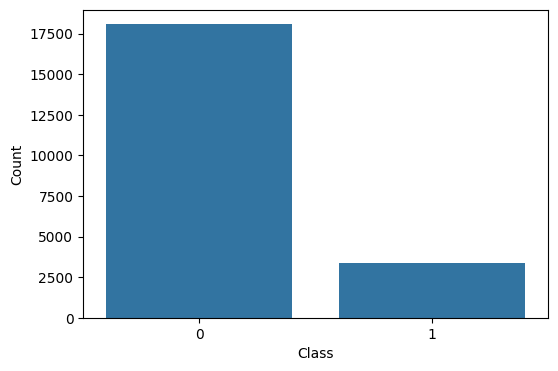

In [12]:
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.countplot(x='outcome', data=inspections_review_processed)
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

## models

In [13]:

X = inspections_review_processed[['processed_text','sentiment','num_reviews','category','prev_inspection_outcome','rating']]
y = inspections_review_processed['outcome']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify = y,random_state=123)

In [14]:
text_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000,ngram_range=(1,2))
cat_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000,ngram_range=(1,2))
X_train_tfidf = text_vectorizer.fit_transform(X_train['processed_text'])
X_train_category = cat_vectorizer.fit_transform(X_train['category'])


In [15]:
X_train_sen = X_train['sentiment'].to_numpy().reshape(-1,1)
X_train_rev = X_train['num_reviews'].to_numpy().reshape(-1,1)
X_train_prev_out = X_train['prev_inspection_outcome'].to_numpy().reshape(-1,1)
X_train_rating = X_train['rating'].to_numpy().reshape(-1,1)
X_train_comb_rev = hstack([X_train_tfidf,X_train_category,X_train_sen,X_train_rev,X_train_prev_out,X_train_rating])
X_train_comb_no_rev = hstack([X_train_category,X_train_prev_out])

In [16]:

X_test_tfidf = text_vectorizer.transform(X_test['processed_text'])
X_test_category = cat_vectorizer.transform(X_test['category'])
X_test_sen = X_test['sentiment'].to_numpy().reshape(-1,1)
X_test_rev = X_test['num_reviews'].to_numpy().reshape(-1,1)
X_test_prev_out = X_test['prev_inspection_outcome'].to_numpy().reshape(-1,1)
X_test_rating = X_test['rating'].to_numpy().reshape(-1,1)
X_test_comb_rev = hstack([X_test_tfidf,X_test_category,X_test_sen,X_test_rev,X_test_prev_out,X_test_rating])
X_test_comb_no_rev = hstack([X_test_category,X_test_prev_out])

In [17]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [18]:
# https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/
#using smote since the classes are not balanced
counter = Counter(y_train)
print('Before', counter)

# oversampling the train dataset using SMOTE
smt = SMOTE()
X_train_sm_rev, y_train_sm = smt.fit_resample(X_train_comb_rev, y_train)
X_train_sm_no_rev, y_train_sm = smt.fit_resample(X_train_comb_no_rev, y_train)
counter = Counter(y_train_sm)
print('After', counter)

Before Counter({0: 14456, 1: 2692})
After Counter({0: 14456, 1: 14456})


In [19]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

In [156]:
svm = SVC(kernel="linear",class_weight='balanced')
svm.fit(X_train_sm_no_rev,y_train_sm)
svm_pred = svm.predict(X_test_comb_no_rev)
print("\nSVM Classification Report:\n", classification_report(y_test, svm_pred))


SVM Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.58      0.70      3615
           1       0.22      0.63      0.32       673

    accuracy                           0.59      4288
   macro avg       0.56      0.61      0.51      4288
weighted avg       0.79      0.59      0.64      4288



In [ ]:
svm_rev = SVC(kernel="linear",class_weight='balanced')
svm_rev.fit(X_train_sm_rev,y_train_sm)
svm_rev_pred = svm_rev.predict(X_test_comb_rev)
print("\nSVM Classification Report:\n", classification_report(y_test, svm_rev_pred))

In [20]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
xgb_params = {
    'max_depth': [None,3,5],
    'min_child_weight':[1,5]
}
xgb_model = XGBClassifier(learning_rate=0.1,objective='binary:logistic',scale_pos_weight = 1)
xgb_clf = GridSearchCV(xgb_model,param_grid=xgb_params).fit(X_train_sm_no_rev,y_train_sm)
xgb_clf.best_estimator_
y_pred = xgb_clf.predict(X_test_comb_no_rev)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.72      0.80      3615
           1       0.26      0.53      0.35       673

    accuracy                           0.69      4288
   macro avg       0.58      0.63      0.57      4288
weighted avg       0.79      0.69      0.73      4288



In [90]:
xgb_params = {
    'max_depth': [None,3,5],
    'min_child_weight':[1,5]
}
xgb_model = XGBClassifier(learning_rate=0.1,objective='binary:logistic',scale_pos_weight = 1)
xgb_clf_rev = GridSearchCV(xgb_model,param_grid=xgb_params).fit(X_train_sm_rev,y_train_sm)
print(xgb_clf_rev.best_estimator_)
y_pred = xgb_clf_rev.predict(X_test_comb_rev)
print(classification_report(y_test, y_pred))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)
              precision    recall  f1-score   support

           0       0.87      0.90      0.88      3615
           1       0.33      0.26      0.29       673

    accuracy                           0.80      4288
   macro avg       0.60  

### Logistic Regression

In [122]:
log_params = [{'C': np.logspace(-2,1,4)}]

In [123]:
log_model = LogisticRegression(max_iter=10000, class_weight='balanced',random_state=123) 
log_clf = GridSearchCV(log_model,param_grid=log_params,cv=5,n_jobs=-1).fit(X_train_sm_no_rev,y_train_sm)
log_clf.best_estimator_
y_pred = log_clf.predict(X_test_comb_no_rev)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.56      0.69      3615
           1       0.21      0.62      0.31       673

    accuracy                           0.57      4288
   macro avg       0.55      0.59      0.50      4288
weighted avg       0.78      0.57      0.63      4288



In [77]:
log_clf.best_params_

{'C': np.float64(10.0)}

In [76]:
log_clf = GridSearchCV(log_model,param_grid=log_params,cv=5,n_jobs=-1).fit(X_train_sm_rev,y_train_sm)
y_pred = log_clf.predict(X_test_comb_rev)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.71      0.79      3615
           1       0.25      0.53      0.34       673

    accuracy                           0.68      4288
   macro avg       0.57      0.62      0.56      4288
weighted avg       0.79      0.68      0.72      4288



In [21]:
from sklearn.metrics import precision_recall_curve,auc

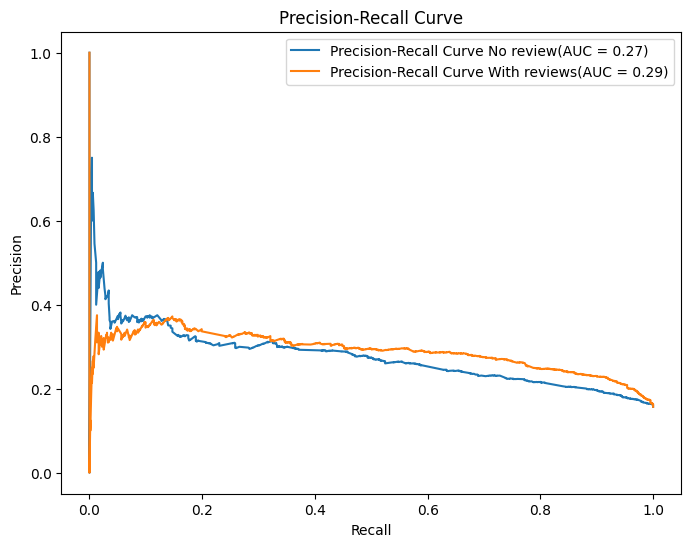

In [101]:
y_scores = xgb_clf.predict_proba(X_test_comb_no_rev)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
auc_score = auc(recall, precision)
y_scores_rev = xgb_clf_rev.predict_proba(X_test_comb_rev)[:, 1]
precision_rev, recall_rev, thresholds_rev = precision_recall_curve(y_test, y_scores_rev)
auc_score_rev = auc(recall_rev, precision_rev)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve No review(AUC = {auc_score:.2f})')
plt.plot(recall_rev, precision_rev, label=f'Precision-Recall Curve With reviews(AUC = {auc_score_rev:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [108]:
log_clf.best_estimator_

LogisticRegression(C=np.float64(10.0), class_weight='balanced', max_iter=10000,
                   random_state=123)

### random forest

In [26]:
rf_params = [{'n_estimators':[100,200],'max_depth':[None,10,15]}]

In [27]:
rf_model = RandomForestClassifier(class_weight='balanced',random_state=123)
rf_clf = GridSearchCV(rf_model,param_grid=rf_params,cv=5,n_jobs=-1).fit(X_train_sm_no_rev,y_train_sm)
print(rf_clf.best_estimator_)
y_pred = rf_clf.predict(X_test_comb_no_rev)
print(classification_report(y_test, y_pred))

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=123)
              precision    recall  f1-score   support

           0       0.89      0.79      0.84      3615
           1       0.29      0.46      0.36       673

    accuracy                           0.74      4288
   macro avg       0.59      0.63      0.60      4288
weighted avg       0.79      0.74      0.76      4288



In [29]:
cm

array([[2862,  753],
       [ 363,  310]])

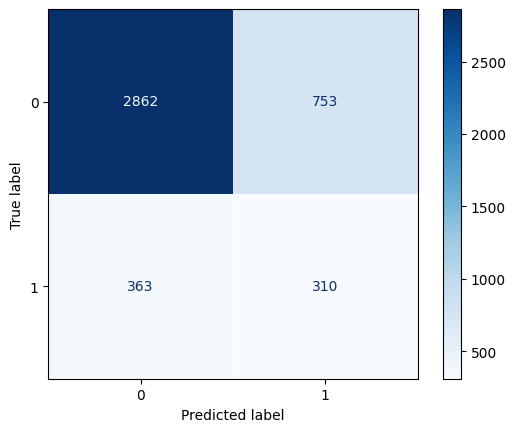

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues) # You can choose other colormaps
plt.show()

In [84]:
rf_clf_rev = GridSearchCV(rf_model,param_grid=rf_params,cv=5,n_jobs=-1).fit(X_train_sm_rev,y_train_sm)
print(rf_clf_rev.best_estimator_)
y_pred = rf_clf_rev.predict(X_test_comb_rev)
print(classification_report(y_test, y_pred))

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=123)
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      3615
           1       0.34      0.31      0.32       673

    accuracy                           0.80      4288
   macro avg       0.61      0.60      0.60      4288
weighted avg       0.79      0.80      0.79      4288



In [22]:
rf_model = RandomForestClassifier(class_weight='balanced',random_state=123,n_estimators=200)
rf_clf_rev = rf_model.fit(X_train_sm_rev,y_train_sm)
y_pred = rf_clf_rev.predict(X_test_comb_rev)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      3615
           1       0.32      0.32      0.32       673

    accuracy                           0.79      4288
   macro avg       0.60      0.60      0.60      4288
weighted avg       0.79      0.79      0.79      4288



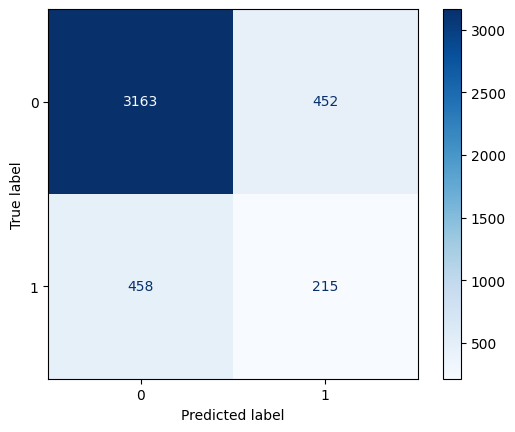

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues) # You can choose other colormaps
plt.show()


In [24]:

n_reviews = X_train_tfidf.shape[1]
n_category = X_train_category.shape[1]
n_numeric = 4  # sentiment, num_reviews, prev_inspection_outcome, rating

importances = rf_clf_rev.feature_importances_

# For reviews and category, you can either:
# a) Show them as a group by summing their importance:
reviews_imp = np.sum(importances[:n_reviews])
category_imp = np.sum(importances[n_reviews:n_reviews + n_category])

# Or
# b) Show top N individual features from each (if you want more detail).

# Numeric features (last 4)
numeric_imps = importances[-n_numeric:]

# Labels
feature_labels = ['Reviews (TF-IDF)', 'Category (TF-IDF)', 'Sentiment', 'Num Reviews', 'Prev Inspection Outcome', 'Rating']
feature_importances = [reviews_imp, category_imp] + list(numeric_imps)


In [1]:
importances = rf_clf.best_estimator_.feature_importances_

n_cat = X_train_category.shape[1]  # e.g., 5000 if max_features=5000
n_num = 1  # assuming only prev_inspection_outcome numeric here

# Sum importance of category TF-IDF features
cat_importance_sum = np.sum(importances[:n_cat])
print(f'Sum of category TF-IDF feature importances: {cat_importance_sum:.3f}')

# Importance of prev_inspection_outcome numeric feature
num_importance = importances[-n_num]
print(f'Importance of prev_inspection_outcome: {num_importance:.3f}')

NameError: name 'rf_clf' is not defined

In [141]:
terms = cat_vectorizer.get_feature_names_out()
cat_importances = importances[:n_cat]

# Get indices sorted by importance descending
top_indices = np.argsort(cat_importances)[::-1][:20]  # top 20

print("Top 20 Category Features:")
for i in top_indices:
    print(f"{terms[i]}: {cat_importances[i]:.4f}")

Top 20 Category Features:
restaurant: 0.0750
bar: 0.0262
american: 0.0232
shop: 0.0195
delivery: 0.0189
grocery: 0.0167
store: 0.0166
mexican: 0.0158
asian: 0.0154
food: 0.0151
pizza: 0.0148
fast: 0.0137
cafe: 0.0134
takeout: 0.0134
italian: 0.0125
chinese: 0.0119
seafood: 0.0116
breakfast: 0.0113
sandwich: 0.0112
japanese: 0.0103
